In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def exact_solution(x, t):
        
        u = np.zeros_like(x)

        if t <= 1:
            u[(x <= 1)]                = 0
            u[(x > 1) & (x <= t+2)]    = (x[(x > 1) & (x <= t+2)] - 1)/(t + 1)
            u[(x > t+2) & (x <= t+3)]  = 1
            u[(x > t+3) & (x <= 4)]    = (4 - x[(x > t+3) & (x <= 4)])/(1 - t)
            u[(x > 4) & (x <= 6)]      = 0
            u[(x > 6) & (x <= 7 - t)]  = (6 - x[(x > 6) & (x <= 7 - t)])/(1 - t)
            u[(x > 7 - t) & (x <= 8 - t)] = -1
            u[(x > 8 - t) & (x <= 9)]  = (x[(x > 8 - t) & (x <= 9)] - 9)/(t + 1)
            u[(x > 9)]                 = 0

        elif t <= 3:
            u[(x <= 1)]                   = 0
            u[(x > 1) & (x <= t+2)]       = (x[(x > 1) & (x <= t+2)] - 1)/(t + 1)
            u[(x > t+2) & (x <= t/2+3.5)] = 1
            u[(x > t/2+3.5) & (x <= -t/2+6.5)] = 0
            u[(x > -t/2+6.5) & (x <= 8 - t)] = -1
            u[(x > 8 - t) & (x <= 9)]     = (x[(x > 8 - t) & (x <= 9)] - 9)/(t + 1)
            u[(x > 9)]                    = 0

        else:
            u[(x <= 1)]            = 0
            u[(x > 1) & (x <= 5)]  = (x[(x > 1) & (x <= 5)] - 1)/(t + 1)
            u[(x > 5) & (x <= 9)]  = (x[(x > 5) & (x <= 9)] - 9)/(t + 1)
            u[(x > 9)]             = 0

        return u

In [ ]:
class Conservative_solver():

    def __init__(self, N_grid, t_final, dt_portion=0.90, x_min=0.0, x_max=10.0):
        self.x_min = x_min
        self.x_max = x_max
        self.N_grid = N_grid
        self.grid = np.linspace(x_min, x_max, N_grid+1)
        self.dx = self.grid[1] - self.grid[0]
        self.t_final = t_final
        self.dt_portion = dt_portion

        self.u = self.initial_cond()
        # The stability limit is defined by CFL contition. Here maximum of u remains 1.0, maximum characteristic speeds remains 1.0
        self.dt = self.dt_portion * self.dx / np.max(np.abs(self.u))
        
    def initial_cond(self):
        x_val = self.grid
        u = np.zeros_like(x_val)

        # Generate mask for each interval
        u[(x_val >= 0) & (x_val < 1)] = 0
        u[(x_val >= 1) & (x_val < 2)] = x_val[(x_val >= 1) & (x_val < 2)] - 1
        u[(x_val >= 2) & (x_val < 3)] = 1
        u[(x_val >= 3) & (x_val < 4)] = 4 - x_val[(x_val >= 3) & (x_val < 4)]
        u[(x_val >= 4) & (x_val < 6)] = 0
        u[(x_val >= 6) & (x_val < 7)] = 6 - x_val[(x_val >= 6) & (x_val < 7)]
        u[(x_val >= 7) & (x_val < 8)] = -1
        u[(x_val >= 8) & (x_val < 9)] = x_val[(x_val >= 8) & (x_val < 9)] - 9
        u[(x_val >= 9) & (x_val <= 10)] = 0

        return u


    def flux(self, u):
        return 0.5 * u**2

    def godunov_flux(self, ul, ur):
        """
        exact Riemann solution for Burgers. Here velocity = u

        """
        if (ul >= 0) and (ur >= 0):
            if ul > ur:
                return self.flux(ul)
            else:
                return self.flux(ul)
        elif (ul <= 0) and (ur <= 0):
            if ul > ur:
                return self.flux(ur) 
            else:
                return self.flux(ur)
        elif (ul >= 0) and (ur <= 0):
            s = (self.flux(ur) - self.flux(ul)) / (ur - ul)
            return self.flux(ul) if s >= 0 else self.flux(ur)
        else:
            return 0
    
    def update(self, dt):
        # dt may change during update, should be considered as an input
        u = self.u
        n_mid = len(u) - 1

        # Flux is defined on every midpoint/interface
        F = np.zeros(n_mid)
        for i in range(n_mid):
            F[i] = self.godunov_flux(u[i], u[i+1])

        self.u[1:-1] = self.u[1:-1] - (dt/self.dx)*(F[1:] - F[:-1])


    def solve(self):
        
        t = 0.0
        dt = self.dt
        while t < self.t_final:
            
            if t > (self.t_final - dt):
                # This step ensures that the final step updates exactly to t_final
                dt = self.t_final - t
            t = t + dt

            self.update(dt)

    def computation(self):
        exact_sol = exact_solution(self.grid, self.t_final)

        self.solve()
        error = np.abs(exact_sol - self.u)
        L2_norm = np.sqrt(np.sum(error**2) * self.dx)
        Linf_norm = np.max(error)

        return L2_norm, Linf_norm, self.u, exact_sol, error
    
    def result(self):

        computation_result = self.computation()
        result = {
            'Grid': self.N_grid,
            't_final': self.t_final,
            'L_2 error': computation_result[0],
            'L_inf error': computation_result[1],
            'numerical solution': computation_result[2],
            'exact solution': computation_result[3],
            'abs error': computation_result[4]
        }

        return result

In [ ]:
times = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
grids = [200, 400]

all_results = {N: {} for N in grids}

for N in grids:
    for t in times:
        solver = Conservative_solver(N_grid=N, t_final=t)
        results = solver.result()  
        all_results[N][t] = results


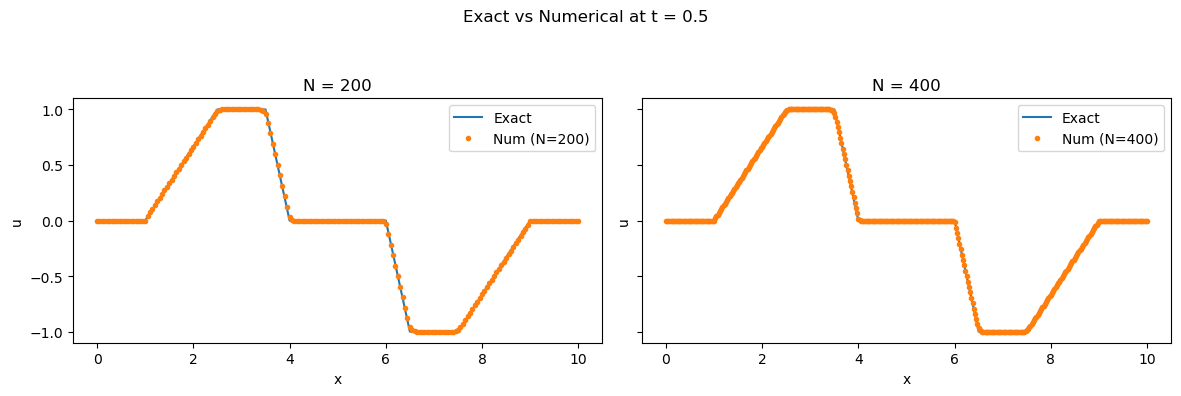

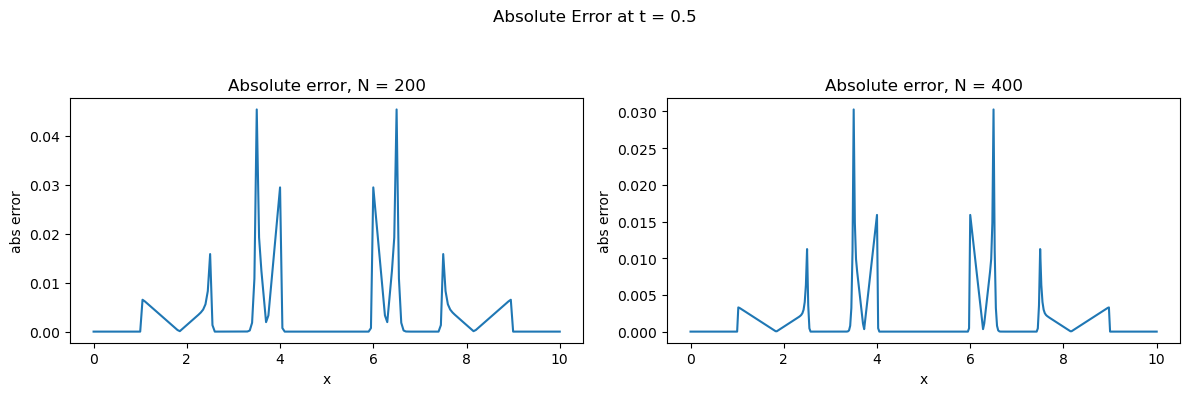

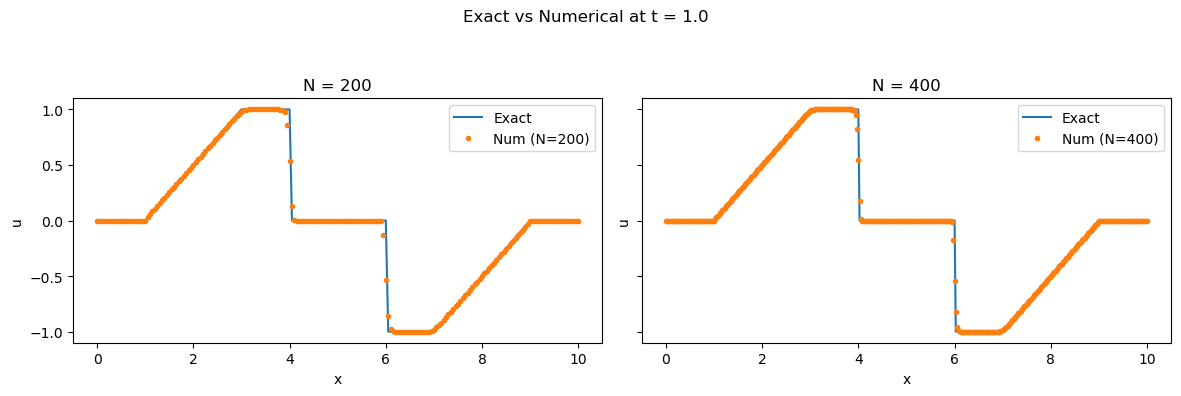

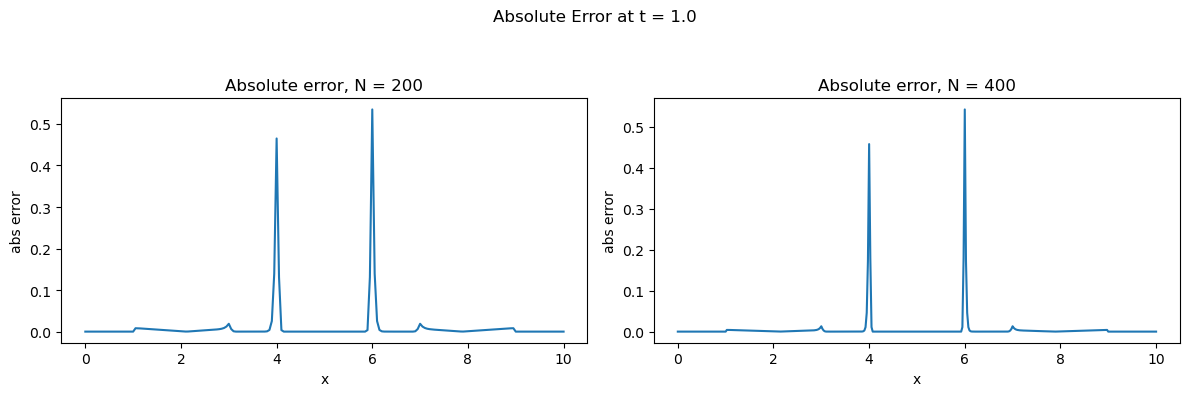

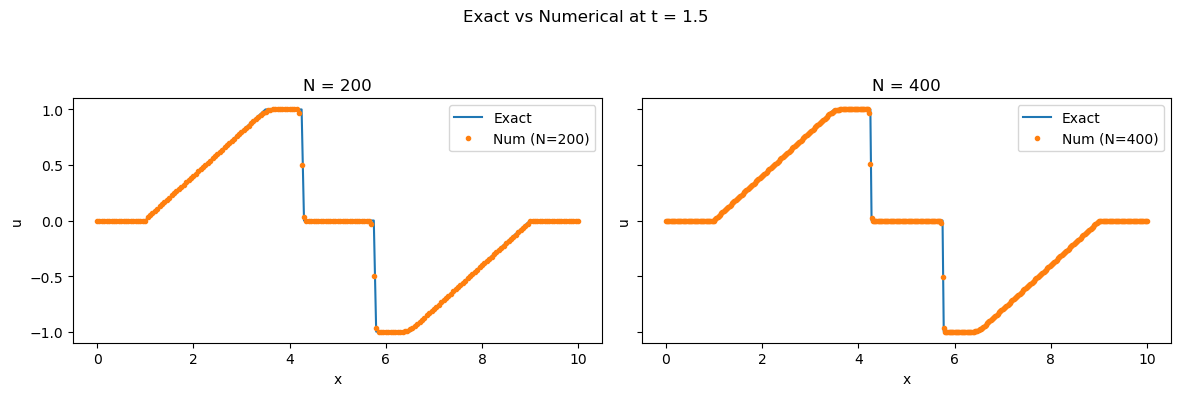

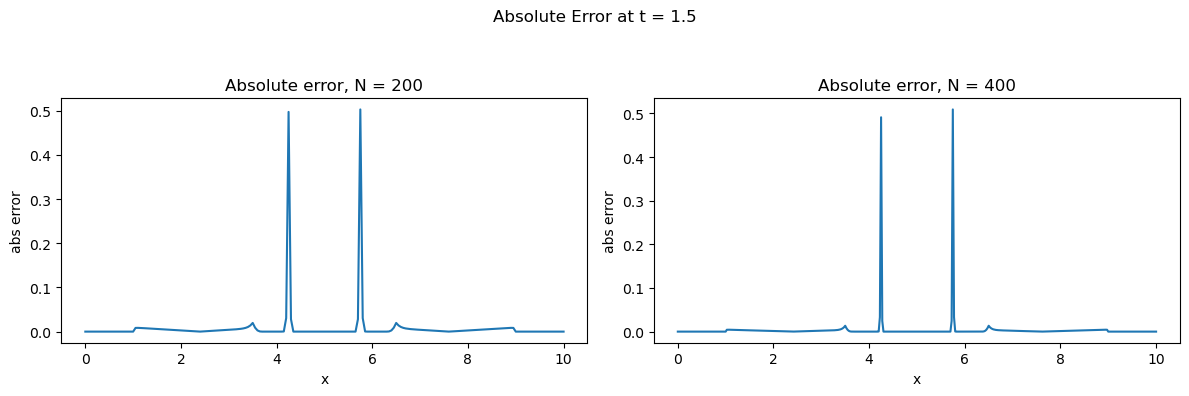

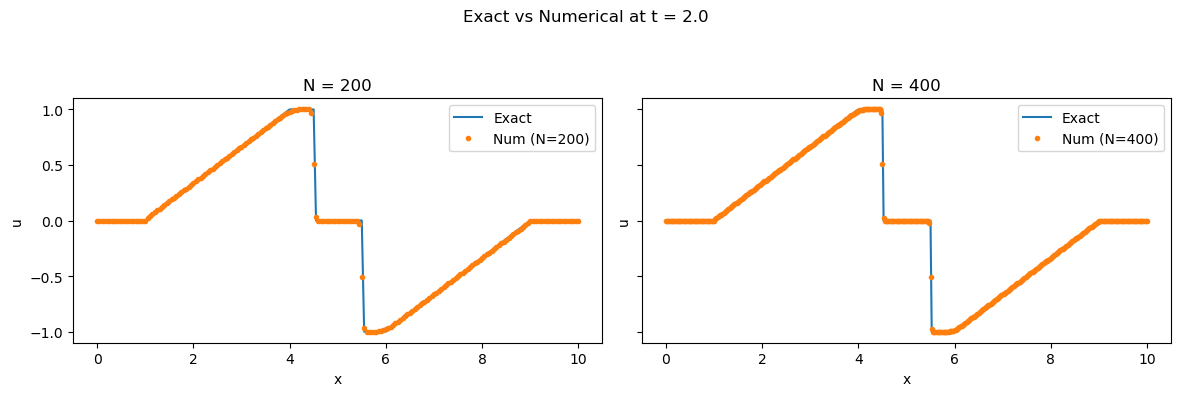

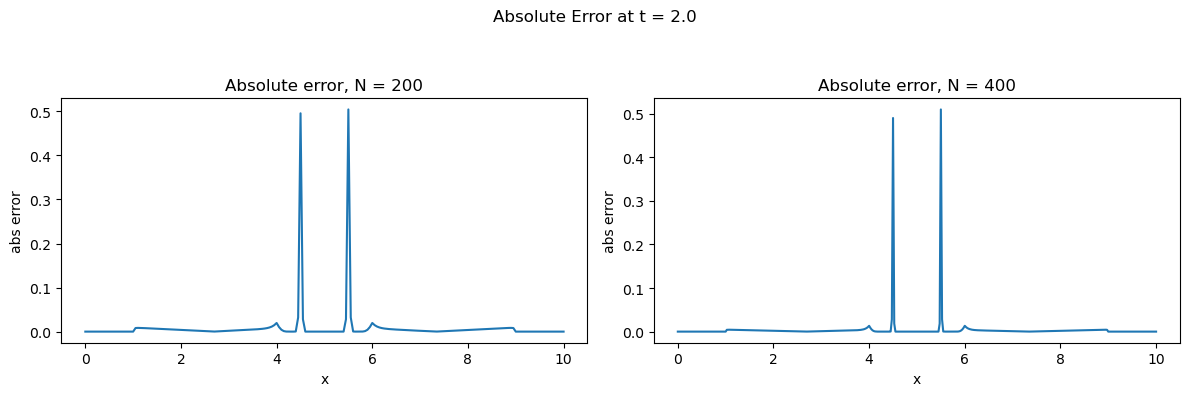

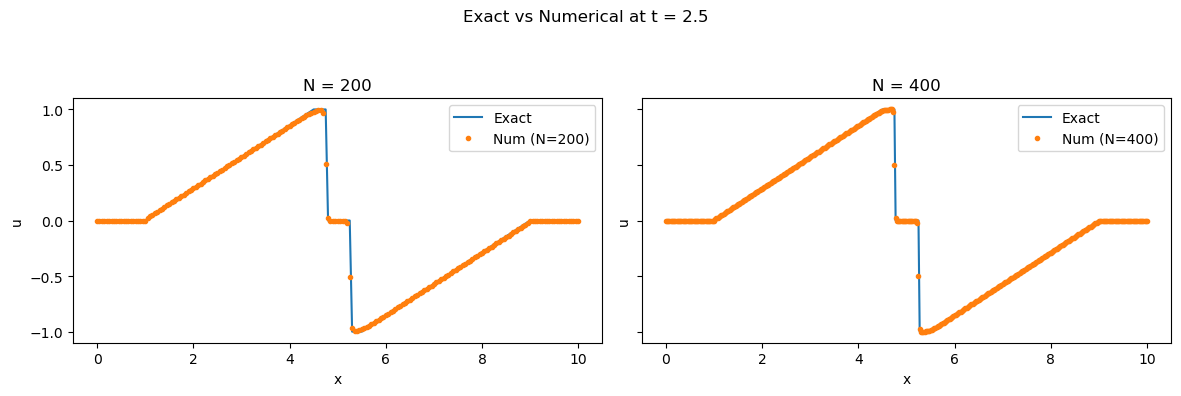

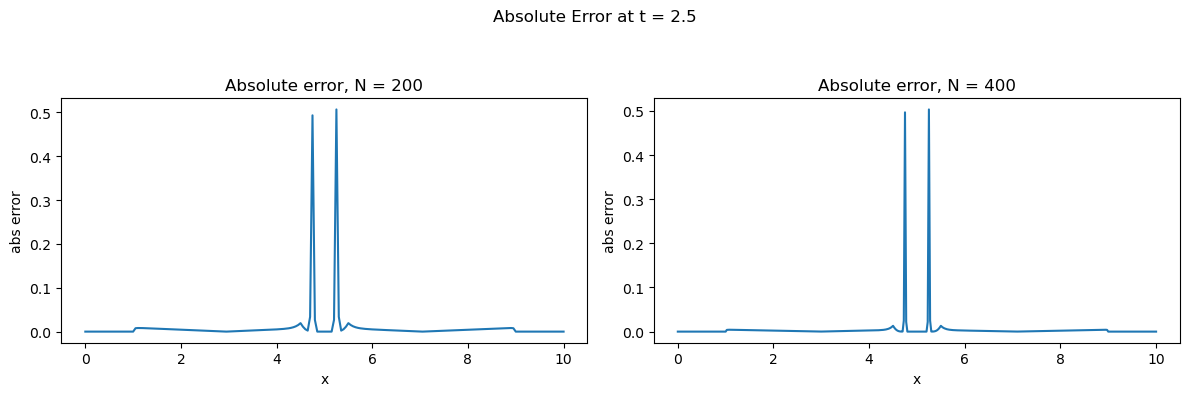

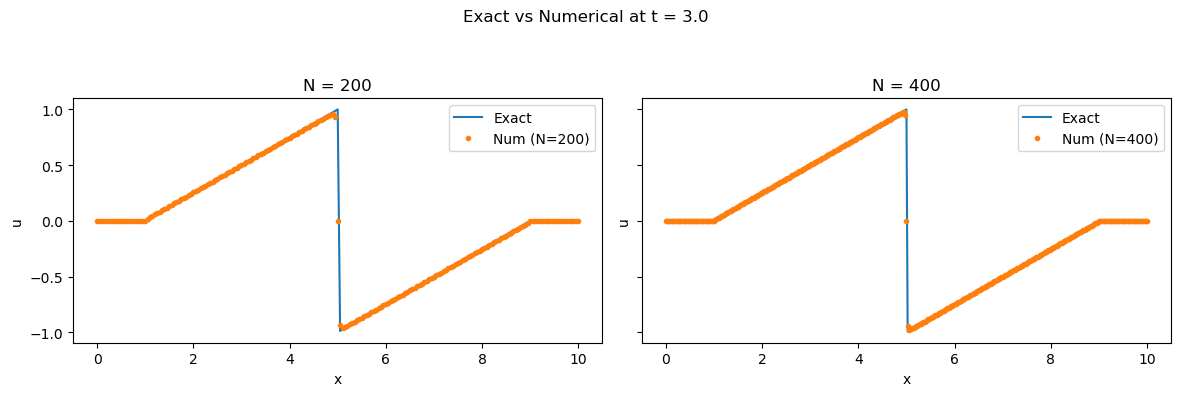

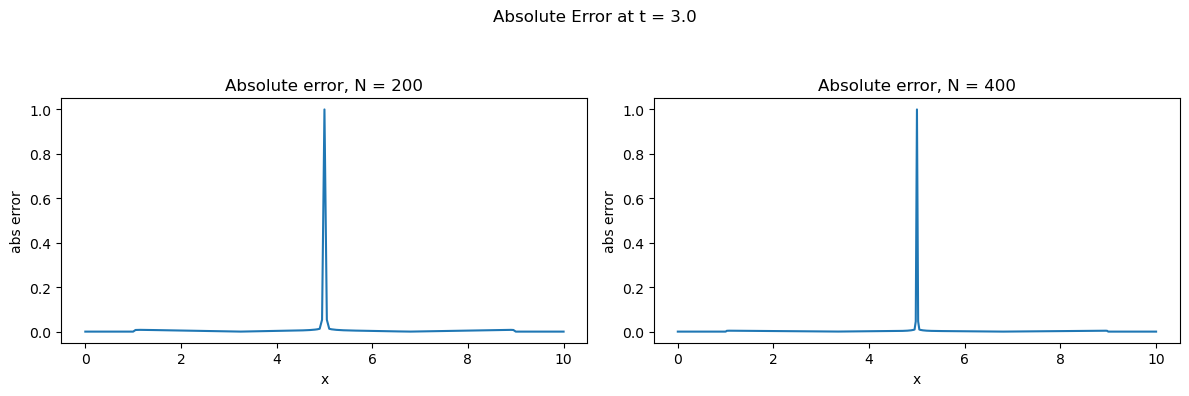

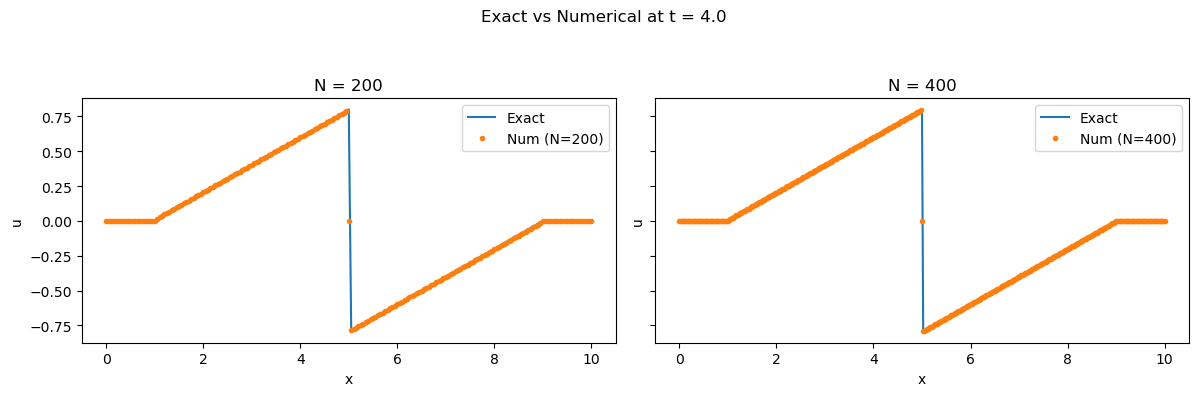

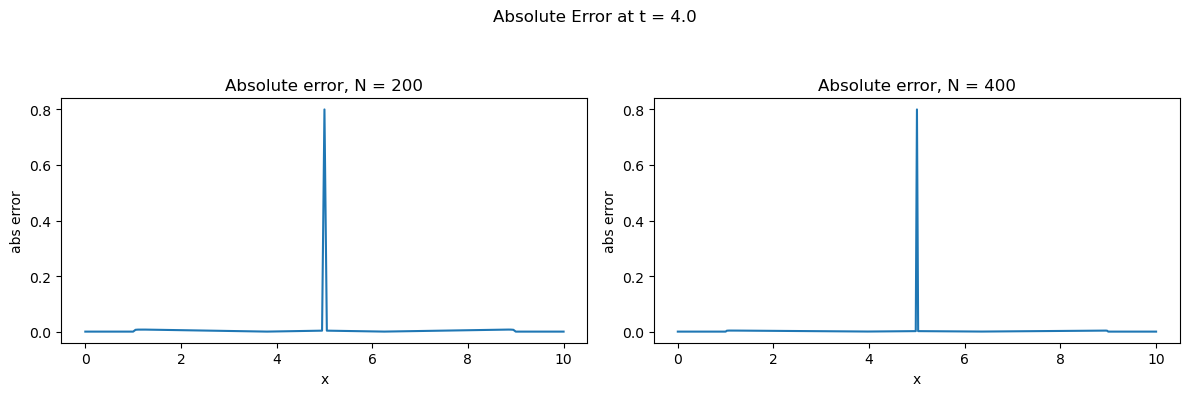

In [ ]:
for t in times:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    for ax, N in zip(axes, grids):
        d = all_results[N][t]
        plot_grid = np.linspace(0.0, 10.0, N+1)
        ax.plot(plot_grid, d['exact solution'], '-', label='Exact')
        ax.plot(plot_grid, d['numerical solution'], 'o', markersize=3, label=f'Num (N={N})')
        ax.set_title(f'N = {N}')
        ax.set_xlabel('x')
        ax.set_ylabel('u')
        ax.legend()
    fig.suptitle(f'Exact vs Numerical at t = {t}')
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=False)
    for ax, N in zip(axes, grids):
        d = all_results[N][t]
        plot_grid = np.linspace(0.0, 10.0, N+1)
        ax.plot(plot_grid, d['abs error'], '-')
        ax.set_title(f'N = {N}')
        ax.set_xlabel('x')
        ax.set_ylabel('abs error')
    fig.suptitle(f'Absolute Error at t = {t}')
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

In [28]:
rows = []
for t in times:
    L2_200   = all_results[200][t]['L_2 error']
    Linf_200 = all_results[200][t]['L_inf error']
    L2_400   = all_results[400][t]['L_2 error']
    Linf_400 = all_results[400][t]['L_inf error']

    conv_L2   = np.log(L2_200 / L2_400) / np.log(2)
    conv_Linf = np.log(Linf_200 / Linf_400) / np.log(2)
    rows.append({
        't':              t,
        'L2 (N=200)':     L2_200,
        'Linf (N=200)':   Linf_200,
        'L2 (N=400)':     L2_400,
        'Linf (N=400)':   Linf_400,
        'conv rate L2':   conv_L2,
        'conv rate Linf': conv_Linf
    })

df = pd.DataFrame(rows).set_index('t')
print(df)

     L2 (N=200)  Linf (N=200)  L2 (N=400)  Linf (N=400)  conv rate L2  \
t                                                                       
0.5    0.023486      0.045347    0.012207      0.030268      0.944038   
1.0    0.170271      0.534953    0.125863      0.542289      0.435984   
1.5    0.159246      0.502787    0.112431      0.508977      0.502211   
2.0    0.159388      0.504373    0.112350      0.509824      0.504543   
2.5    0.159485      0.506716    0.112359      0.503290      0.505302   
3.0    0.224662      1.000000    0.158613      1.000000      0.502242   
4.0    0.179231      0.800000    0.126616      0.800000      0.501355   

     conv rate Linf  
t                    
0.5    5.832038e-01  
1.0   -1.964831e-02  
1.5   -1.765171e-02  
2.0   -1.550722e-02  
2.5    9.789561e-03  
3.0   -1.409508e-14  
4.0   -1.505610e-14  


## Discussion
We observe no dissipation and dispersion for the numerical solution. The largest absolute error exists where the exact solution is most discontinuous. There are some grid points 'in' the discontinuity, e.g. they appears in the vertical line of exact solution. Because once $u_k$ is in the discontinuity, flux difference on $u_{k+1}$ will not give enough update to reach the other piece of discontinuity (from 0 to 1), so there will always be a nodes there which generate large local error. Inifite norm only consider this error, so it does not converge after the exact solution generates shock wave. L2 norm take the global view, thus has converge rate from 0.5 to 1 for different step.